In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGenV2, AffineGridGen, DenseAffine3DGridGen, DenseAffine3DGridGen_rotate
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
cgen = CylinderGridGenV2(64, 128)

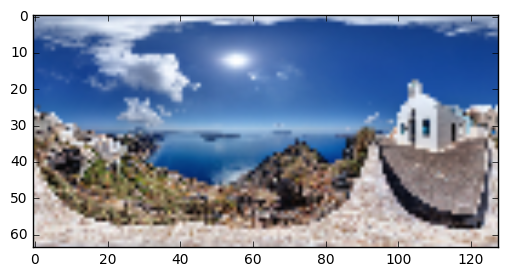

In [3]:
from PIL import ImageFilter
img = Image.open('equi.png').convert('RGB').resize((128,64))
img = np.array(img)/255.0
plt.imshow(img)

In [4]:
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0)))

In [5]:
st = STN()

In [6]:
input2 = Variable(torch.from_numpy(np.array([[0.6]]).astype(np.float32)))
print(input2)

Variable containing:
 0.6000
[torch.FloatTensor of size 1x1]



In [7]:
out = cgen(input2)


In [8]:
imgout = st(input1, out)

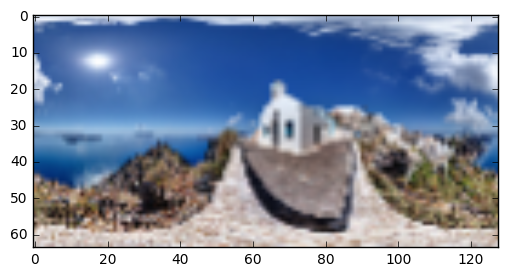

In [9]:
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [10]:
class CylinderTransformer(nn.Module):
    def __init__(self):
        super(CylinderTransformer, self).__init__()
        self.s = STN()
        self.g = CylinderGridGenV2(64, 128, lr = 1)
    def forward(self,input1, input2):
        out = self.g(input2)
        out2 = self.s(input1, out)
        return out2

In [11]:
target = imgout.detach()
tc = CylinderTransformer()
crt = nn.L1Loss()

In [12]:
x = []
y = []
g_ = []

for i in np.arange(0,5,0.002):
    x.append(i)
    input2 = Variable(torch.from_numpy(np.array([[i]], dtype=np.float32)) , requires_grad = True)
    out = tc(input1, input2)
    err = crt(out, target)
    err.backward()
    y.append(err.data[0])
    g_.append(input2.grad.data[0][0])

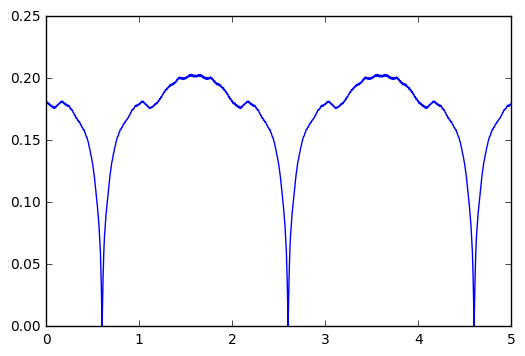

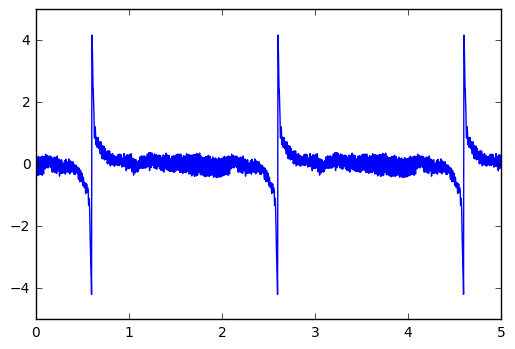

In [13]:
plt.figure()
plt.plot(x,y)
plt.figure()
plt.plot(x,g_)

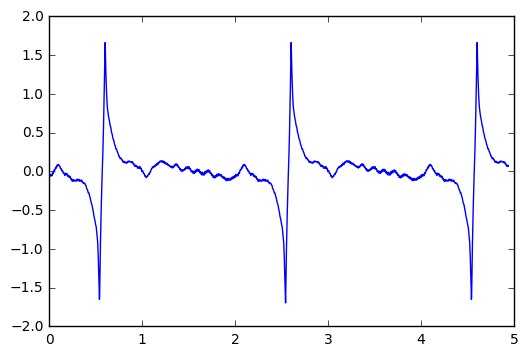

In [14]:
g__ = []
for i in range(len(np.array(g_))-30):
    g__.append(np.mean(g_[i:i+30]))
    
plt.plot(x[:-30], g__)

In [15]:
class Test():
    def __init__(self, height, width):
        
        self.height, self.width = height, width
        
        self.grid = np.zeros( [self.height, self.width, 3], dtype=np.float32)
        self.grid[:,:,0] = np.expand_dims(np.repeat(np.expand_dims(np.arange(-1, 1, 2.0/self.height), 0), repeats = self.width, axis = 0).T, 0)
        self.grid[:,:,1] = np.expand_dims(np.repeat(np.expand_dims(np.arange(-1, 1, 2.0/self.width), 0), repeats = self.height, axis = 0), 0)
        self.grid[:,:,2] = np.ones([self.height, width])
        self.grid = torch.from_numpy(self.grid.astype(np.float32))


In [16]:
t = Test(30,60)

In [17]:
t.grid.size()

torch.Size([30, 60, 3])

In [18]:
theta = t.grid[:,:,0] * np.pi/2 + np.pi/2
theta


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.1047  0.1047  0.1047  ...   0.1047  0.1047  0.1047
 0.2094  0.2094  0.2094  ...   0.2094  0.2094  0.2094
          ...             ⋱             ...          
 2.8274  2.8274  2.8274  ...   2.8274  2.8274  2.8274
 2.9322  2.9322  2.9322  ...   2.9322  2.9322  2.9322
 3.0369  3.0369  3.0369  ...   3.0369  3.0369  3.0369
[torch.FloatTensor of size 30x60]

In [19]:
phi = t.grid[:,:,1] * np.pi + np.pi

In [20]:
phi


 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
          ...             ⋱             ...          
 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
 0.0000  0.1047  0.2094  ...   5.9690  6.0737  6.1785
[torch.FloatTensor of size 30x60]

In [21]:
x = torch.sin(theta) * torch.cos(phi)
y = torch.sin(theta) * torch.sin(phi)
z = torch.cos(theta)

In [22]:
showx = x[10:20,10:20].numpy()
showy = y[10:20,10:20].numpy()
showz = z[10:20,10:20].numpy()

In [23]:
from mpl_toolkits.mplot3d import Axes3D

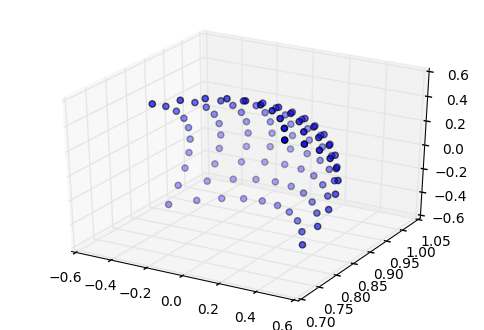

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(showx.flatten(), showy.flatten(), showz.flatten())

In [25]:
x = x + 0.4

In [26]:
r = torch.sqrt(x**2 + y**2 + z**2)
r2 = torch.sqrt(x**2 + y**2)

In [27]:
theta2 = torch.acos(z/r)

In [28]:
phi2 = torch.atan(y/x)  + np.pi * x.lt(0).type(torch.FloatTensor) * (y.ge(0).type(torch.FloatTensor) - y.lt(0).type(torch.FloatTensor))

In [29]:
theta_show = theta2.numpy().flatten()/(np.pi/2) - 1
phi_show = phi2.numpy().flatten()/(np.pi)

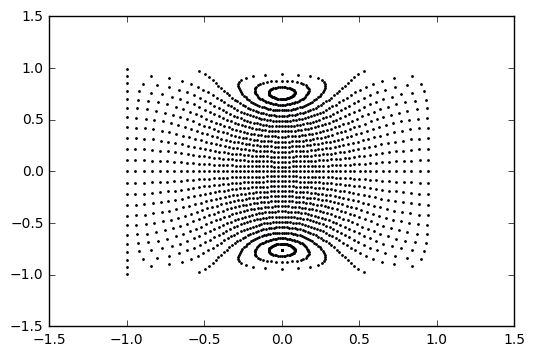

In [30]:
plt.scatter(phi_show, theta_show, 1)

In [31]:
d = DenseAffine3DGridGen(64,128)

In [32]:
iden = torch.from_numpy(np.array([[1.2,0,0,0],[0,1,0,0],[0,0,1,0]]).astype(np.float32)) + 0.2*torch.rand([1,3,4])

In [33]:
iden2 = iden.view(1,1,1,12).repeat(1,64,128,1)

In [34]:
iden2 = Variable(iden2, requires_grad = True)

In [35]:
out = d(iden2)

In [36]:
rnd = Variable(torch.rand([1,64,128,2]))

In [37]:
out.backward(rnd.data)

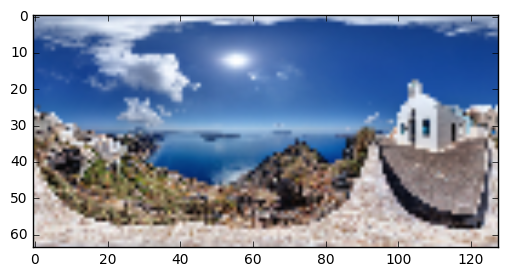

In [38]:
plt.imshow(img)
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0)))

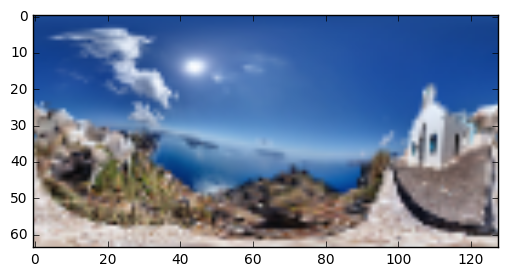

In [39]:
imgout = st(input1, out)
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [40]:
grid = out.data.numpy()

In [41]:
out.size()

torch.Size([1, 64, 128, 2])

In [42]:
input1.size()

torch.Size([1, 64, 128, 3])

In [43]:
d2 = DenseAffine3DGridGen_rotate(64,128)

In [44]:
input2 = Variable(torch.from_numpy(np.array([[0.8]]).astype(np.float32)))

In [45]:
out2 = d2(iden2, input2)

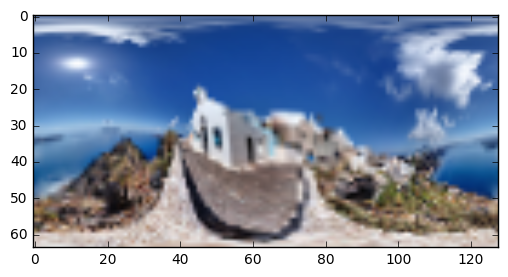

In [46]:
imgout = st(input1, out2)
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [47]:
grid_data = grid[0]

In [48]:
delta = 0.025
x = np.arange(-1, 1, 2/128.0)
y = np.arange(-1, 1, 2/64.0)
X, Y = np.meshgrid(x, y)
Z1 = grid_data[:,:,0]
Z2 = grid_data[:,:,1]

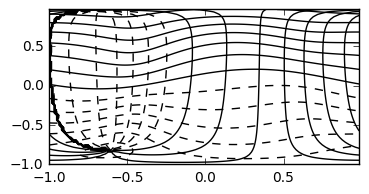

In [49]:
fig = plt.figure(figsize=(4,2))
CS = plt.contour(X, Y, Z1, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)